## Setup

We begin by loading the *poems* package and setting our output directory.

In [1]:
setwd('C:/Users/tm/Downloads/utas/thesis/chapter1/maria/poems')
library(poems)
OUTPUT_DIR='C:/Users/tm/Downloads/utas/thesis/chapter1/maria/poems'

### read data

In [2]:
#this is the land area of maria island
baselayer=read.csv('baselayer.csv')
baselayer=subset(baselayer, grid == 0)
landarea=c(as.numeric(row.names(baselayer)))

In [3]:
#population size
#estimated via cormack jolly seber
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Maria/jolly%20seber%20maria%20island.ipynb
population_est=read.csv('population.csv')
population_size=as.array(population_est$population)

In [4]:
#habitat suitability map
#estimated via vegetation,altitude and seabird colony
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Maria/habitat%20suitability%20maria%20island%20billie.ipynb
suitability=read.csv('suitability.csv')

In [5]:
#set the floor of habitat suitability to 0.7
suitability$pred=(suitability$pred-min(suitability$pred))/(max(suitability$pred)-min(suitability$pred))*(1-0.7)+0.7

## Workflow

The *poems* workflow, which implements a pattern-oriented modeling (POM) approach 
(Grimm et al., 2005), is achieved via a framework of interoperable components:


The workflow is summarized by the following six steps:

1. Build the population model for the study region.
1. Build generators for dynamically generating model parameters.
1. Sample model and generator parameters for each simulation.
1. Build a simulation manager to run each simulation.
1. Build a results manager to generate summary results (metrics).
1. Build a validator to select a model ensemble.

### Step 1: Build the population model for the study region
Create a model template using the *PopulationModel* class. If the model is spatially
explicit, then define the study region via the *Region* class. All fixed model inputs,
such as environmental correlations, as well as any user-defined functions for processes
such as harvesting, should be set at this stage.

We could create these components in any order and set model parameters separately, but 
let's setup our study region, generate environmental correlations, and define a harvest
function prior to initializing the template model with all the fixed parameters.

##### Study region
First, we'll define our study region maria island with some longitude-latitude
coordinates.

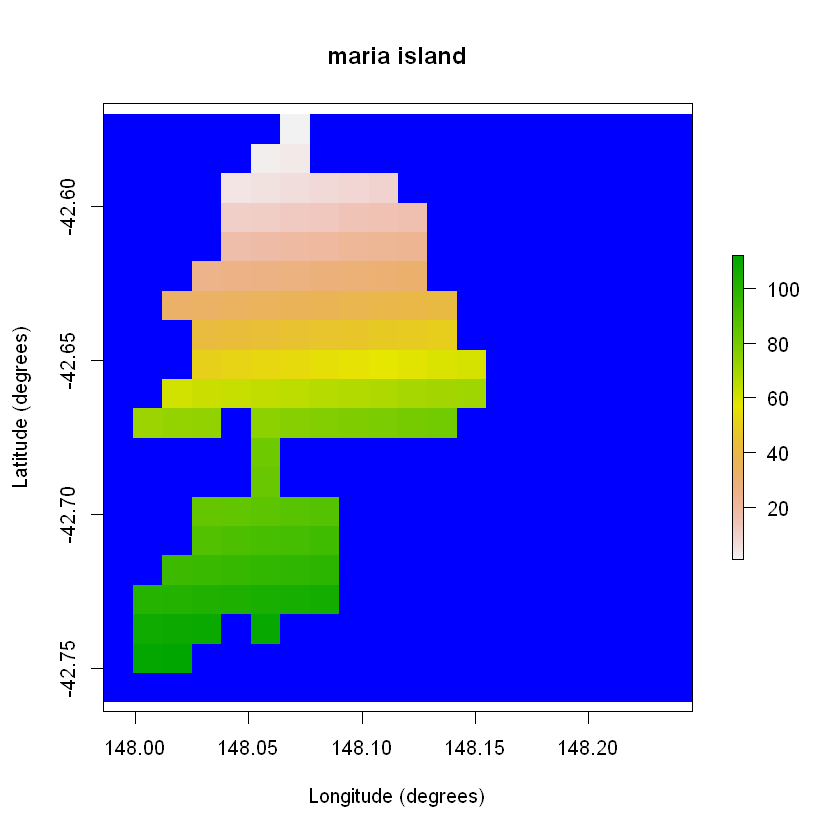

In [6]:
#build the raster of maria island
coordinates <- data.frame(x = rep(seq(147.992312, 148.252213, 0.01299515), 20),
                          y = rep(seq(-42.755783, -42.564998, 0.00953926),each= 20))
template_raster <- Region$new(coordinates = coordinates)$region_raster # full extent
template_raster[][-landarea] <- NA 

region <- Region$new(template_raster = template_raster)

raster::plot(region$region_raster, main = "maria island",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue",)

##### Environmental correlation
Next, we'll define a distance-based spatial correlation for applying environmental 
stochasticity within our model. The generated correlation data is compacted for 
computational efficiency (with large-scale models).

In [7]:
# Distance-based environmental correlation (via a compacted Cholesky decomposition)
env_corr <- SpatialCorrelation$new(region = region, amplitude = 0.4, breadth = 500)
correlation <- env_corr$get_compact_decomposition(decimals = 2)

##### Template model
Finally, we can build our template model with these and other fixed parameters.

leslie matrix [annual]

[0.         0.202  0.5444 1.1944 0.826 0.5833]

[0.78169418 0.         0.         0.         0.         0.        ]

[0.         0.65399346 0.         0.         0.         0.        ]

[0.         0.         0.56338836 0.         0.         0.        ]

[0.         0.         0.         0.49310958 0.         0.        ]

[0.         0.         0.         0.         0.43568764 0.        ]

this matrix is estimated via mark recapture data from billie


https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Maria/leslie%20matrix%20maria%20island.ipynb

In [8]:
leslie_matrix=c(0.  ,   0.2020202,  0.54444444, 1.19444444, 0.82608696, 0.58333333, 0.78169418, 0.   ,0.,
       0.   , 0.   , 0.   , 0.   , 0.65399346, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.56338836, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.49310958, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.43568764  , 0.    )
agegroup=c("y0","y1","y2","y3","y4","y5")

In [9]:
# Population (simulation) model template for fixed parameters
stage_matrix <- matrix(leslie_matrix, nrow = 6, ncol = 6, byrow = TRUE,
                       dimnames = list(agegroup,agegroup ))
#stage_matrix # examine
model_template <- PopulationModel$new(region = region,
                                      time_steps = 7, # years
                                      populations = region$region_cells, 
                                      stages = 6,
                                      stage_matrix = stage_matrix,
                                      demographic_stochasticity = TRUE,
                                      standard_deviation = 0.05,
                                      correlation = correlation,
                                      density_dependence = "logistic",
                                      results_selection = c("abundance"),)

### Step 2: Build generators for dynamically generating model parameters
Some model parameters are single values, whilst others are represented as arrays and
other multi-value data structures. Usually, we don't wish to sample each individual 
value within these multi-value parameters (in step 3), but to generate them dynamically
via one or more intermediate sampled parameters. Here we build generators for model 
initial abundance, carrying capacity, and dispersal.

##### Habitat suitability
Firstly, our initial abundance and carrying capacity generator utilizes an example
(mock) habitat suitability for our defined study region. 

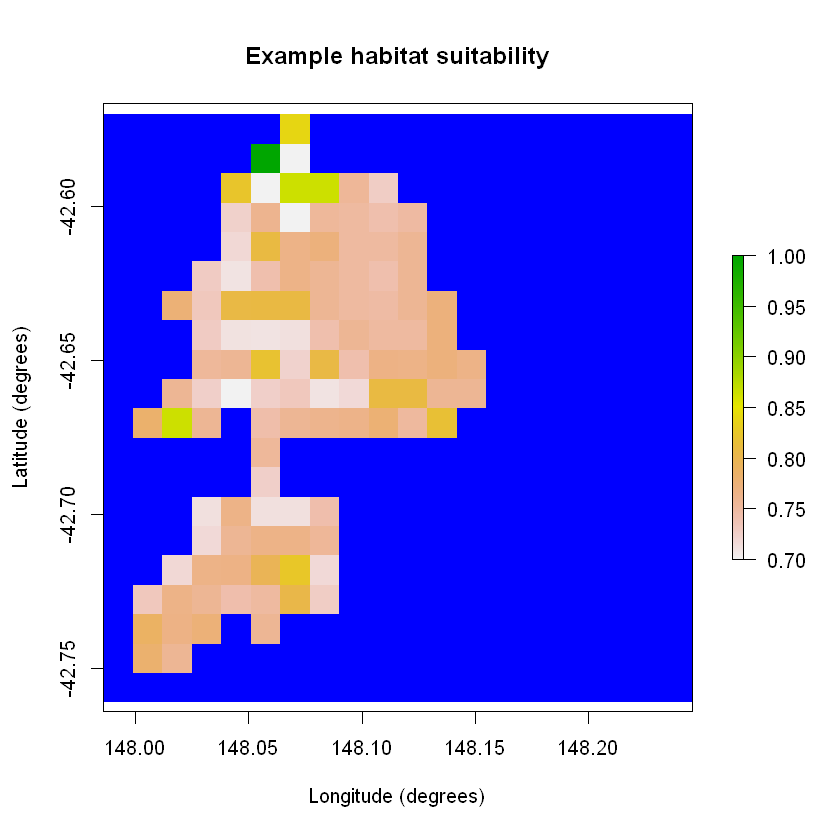

In [10]:
# Example habitat suitability
example_hs=suitability$pred
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- example_hs
raster::plot(example_hs_raster, main = "Example habitat suitability",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

##### Initial abundance and carrying capacity generator
The generator utilizes generic template functionality for user-defined custom
functions. It uses sampled input parameters (initial total abundance and maximum cell
density), along with habitat suitability, to generate the desired output model 
parameters (initial abundance and carrying capacity) via these user-defined functions. 
Generators can also be configured to read values from files or generate values via 
probabilistic distributions. 

In [10]:
# Initial abundance and carrying capacity generated via example habitat suitability
capacity_gen <- Generator$new(description = "Capacity generator",
                              example_hs = example_hs, # template attached
                              inputs = c("initial_n", "density_max"),
                              outputs = c("initial_abundance", "carrying_capacity"))
capacity_gen$add_generative_requirements(list(initial_abundance = "function",
                                              carrying_capacity = "function"))
capacity_gen$add_function_template("initial_abundance",
                                   function_def = function(params) {
                                       settleprob=rep(0,length(params$example_hs))
                                       for (i in 1:10)
                                           {settleprob[i]=0.8}
                                       stats::rmultinom(1, size = params$initial_n,
                                                      prob = settleprob)[,1]
                                       
#                                        #introduced devils are established at the north of the island
#                                        init_abund<<-rep(0, length(params$example_hs))

#                                         init_abund[1]=3
#                                         init_abund[2]=2
#                                         init_abund[3]=7
#                                         init_abund[4]=2
#                                         init_abund[5]=1
#                                        init_abund
                                   },
                                   call_params = c("initial_n", "example_hs"))
capacity_gen$add_function_template("carrying_capacity",
                                   function_def = function(params) {
                                     round(params$density_max*params$example_hs)
                                   },
                                   call_params = c("density_max", "example_hs"))
#capacity_gen$generate(input_values = list(initial_n = 15, density_max = 15)) # test

##### Dispersal generator
Our dispersal generator uses default functionality for generating dispersal rates 
between cells. Its sampled inputs parameterize the distance-based dispersal function
(proportion dispersing and breadth of dispersal). The generator can be configured with 
a dispersal friction helper class object, which calculates equivalent dispersal 
distances for frictional landscapes and coastlines. Here it is used to ensure dispersal 
is not performed directly across the "water" in Maria island. The 
generated dispersal data is calculated via pre-calculated distance data and compacted
for computational efficiency (with large-scale models).

Maria island is 20km * 13km. Dispersal is estimated via mark recapture data from billie. Devils which got recaptured one year apart are taken into the dataset to estimate the annual dispersal distance. 

https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Maria/dispersal%20estimate%20maria%20island.ipynb

In [11]:
# Distance-based dispersal generator
dispersal_gen <- DispersalGenerator$new(region = region,
                                        dispersal_max_distance = 15000, # in m 
                                        dispersal_friction = DispersalFriction$new(),
                                        inputs = c("dispersal_p", "dispersal_b"),
                                        decimals = 5)
dispersal_gen$calculate_distance_data() # pre-calculate
test_dispersal <- dispersal_gen$generate(input_values = list(dispersal_p = 0.174693683, 
                                                             dispersal_b = 3308.05479))
#head(test_dispersal$dispersal_data[[1]])

as(<dsCMatrix>, "dgTMatrix") is deprecated since Matrix 1.5-0; do as(as(., "generalMatrix"), "TsparseMatrix") instead



### Step 3: Sample model and generator parameters for each simulation
In order to explore the model parameter space to find the best models, we generate
Latin hypercube samples of model and generator parameters to be simulated, using the
*LatinHypercubeSampler* class. This class has functionality for generating sample
parameters via Uniform, Normal, Lognormal, Beta, and Triangular distributions.

In [12]:
# Generate sampled values for variable model parameters via LHS
lhs_gen <- LatinHypercubeSampler$new()

#logistic growth model 0.74
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Maria/logistic%20population%20growth%20maria%20island.ipynb
lhs_gen$set_uniform_parameter("growth_rate_max", lower = 0.2, upper = 0.9, decimals = 2)
lhs_gen$set_uniform_parameter("initial_n", lower = 10, upper = 30, decimals = 0)

lhs_gen$set_uniform_parameter("density_max", lower = 0.1, upper = 5, decimals = 0)
lhs_gen$set_uniform_parameter("dispersal_p", lower = 0.09, upper = 0.3, decimals = 4)
lhs_gen$set_uniform_parameter("dispersal_b", lower = 1000, upper = 7000, decimals = 2)
sample_data <- lhs_gen$generate_samples(number = 10000)

#save as pickle
save(sample_data, file="sample data.Rda")

### Step 4: Build a simulation manager to run each simulation
We now wish to run a simulation for each set (or row) of sampled parameters. The
*SimulationManager* class manages the generation of parameters (via the generators),
the running the model simulations, and writing simulation results to disk. It also
maintains a log of each simulation's success and any errors or warnings encountered.

In [13]:
# Create a simulation manager and run the sampled model simulations
sim_manager <- SimulationManager$new(sample_data = sample_data,
                                     model_template = model_template,
                                     generators = list(capacity_gen, dispersal_gen),
                                     parallel_cores = 2,
                                     results_dir = OUTPUT_DIR)
run_output <- sim_manager$run(results_dir = tempdir())
run_output$summary
#dir(OUTPUT_DIR, "*.RData") # includes result files 
#dir(OUTPUT_DIR, "*.txt") # plus simulation log

[1] "9184 of 10000 sample models ran and saved results successfully with warnings"

Note that the output directory contains a R-data result files for each sample simulation
and a simulation log file.

### Step 5: Build a results manager to generate summary results (metrics)
We now wish to collate summary results for each of our simulations via the 
*ResultsManager* class. This manager loads the results from each sample simulation into
an intermediate *PopulationResults* class object, which dynamically generates further 
results. We need to define functions for calculating summary metrics, as well as any 
matrices (one row of values per simulation) that we may be interested in examining. Each
metric (or matrix) is associated with a user-defined function that utilizes results object 
attributes, or alternatively direct access to an attribute may be defined via a string.
Once generated, the result metrics (a data frame) and/or matrices (a list) can be 
accessed via the manager. We may utilize the collated results in a variety of ways. 
However, with the objective of selecting the best models, we wish to compare (or 
validate) these result metrics to (with) known or desired target patterns (in step 6).

In [14]:
results_manager <- ResultsManager$new(simulation_manager = sim_manager,
                                      simulation_results = PopulationResults$new(),
                                      summary_metrics = c("p2","p3","p4","p5","p6","p7"),
                                      summary_matrices = c("n"),
                                      summary_functions = list(
                                        p2 = function(results) {
                                          results$all$abundance[2]
                                        },
                                        p3 = function(results) {
                                          results$all$abundance[3]
                                        },
                                        p4 = function(results) {
                                          results$all$abundance[4]
                                        },
                                        p5 = function(results) {
                                          results$all$abundance[5]
                                        },
                                        p6 = function(results) {
                                          results$all$abundance[6]
                                        },
                                        p7 = function(results) {
                                          results$all$abundance[7]
                                        },
                                        n = "all$abundance"),
                                      parallel_cores = 2)
gen_output <- results_manager$generate()
gen_output$summary
#dir(OUTPUT_DIR, "*.txt") # plus generation log
# results_manager$summary_metric_data
# results_manager$summary_matrix_list

[1] "9184 of 10000 summary metrics/matrices generated from sample results successfully"

In [15]:
#save as pickle
save(results_manager, file="models.Rda")

### Step 6: Build a validator to select a model ensemble
We now select and analyze our 'best' models via a *Validator* class object, which by
default utilizes an approximate Bayesian computation (ABC) approach (Beaumont, Zhang, 
& Balding, 2002) provided by the *abc* library (Csillery et al., 2015). The validator
can be configured appropriately for a problem domain (see the *abc* documentation). 
Here we use the default configuration to select the best 3 models, along with a weight
value, which is indicative of the congruence between each model's summary metrics and 
the corresponding target patterns. Also provided (with the default settings) is a 
diagnostic output (PDF) file, containing statistical information for analyzing the 
contribution of model parameters in the selection/validation process (see the *abc* 
documentation). For our simple demonstration the metrics and corresponding targets are 
relatively trivial, having the aim of producing stable population abundances with high 
harvest. However, the package facilitates the use more complex spatio-temporal metrics 
and targets (demonstrated in more advanced vignettes).

[15, 14, 27, 99, 92, 96, 103]

In [11]:
#load pickle files so no need to retrain
load("models.Rda")
load("sample data.Rda")

In [12]:
#showna
validation_target=results_manager$summary_metric_data
validation_target[!complete.cases(validation_target),]

,index,p2,p3,p4,p5,p6,p7
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,5,NA,NA,NA,NA,NA,NA
9,9,NA,NA,NA,NA,NA,NA
31,31,NA,NA,NA,NA,NA,NA
43,43,NA,NA,NA,NA,NA,NA
47,47,NA,NA,NA,NA,NA,NA
52,52,NA,NA,NA,NA,NA,NA
55,55,NA,NA,NA,NA,NA,NA
75,75,NA,NA,NA,NA,NA,NA
93,93,NA,NA,NA,NA,NA,NA


In [13]:
#list of na
remove_index=which(!complete.cases(validation_target))

In [14]:
# Create a validator for selecting the 'best' example models
if (length(remove_index)==0)    {
    validator <- Validator$new(simulation_parameters = sample_data,
                           simulation_summary_metrics =
                             validation_target[-1],
                           observed_metric_targets = c(p2=14,p3=27,p4=99,p5=92,p6=96,p7=103),
                           output_dir = OUTPUT_DIR)

} else    {
    validator <- Validator$new(simulation_parameters = sample_data[-remove_index,],
                           simulation_summary_metrics =
                             validation_target[-remove_index,][-1],
                           observed_metric_targets = c(p2=14,p3=27,p4=99,p5=92,p6=96,p7=103),
                           output_dir = OUTPUT_DIR)
}

In [20]:
validator$run(tolerance = 0.25, output_diagnostics = TRUE)

12345678910
12345678910


Warning message:
"Validation function generated warning: All parameters are "none" transformed."


In [21]:
#rescale weights as they dont sum up to one
weights=validator$selected_simulations 
weights$weight=weights$weight/sum(weights$weight)

In [22]:
#get result
colSums(sample_data[weights$index,]*replicate(length(sample_data), weights$weight))

growth_rate_max       initial_n     density_max     dispersal_p     dispersal_b 
      0.5542650      19.7791104       2.5603289       0.1921034    3975.4194049

In [23]:
dir(OUTPUT_DIR, "*.pdf") # plus validation diagnostics (see abc library documentation)

[1] "validation_diagnostics.pdf"

We encourage the user to examine the generated diagnostics (PDF) output file, and to
become acquainted with the analysis that this information facilitates (see the *abc* 
documentation). As our simple example only uses two metrics/targets, we can visualize
the congruence of the selected models with the targets via a simple plot.

In [24]:
# install.packages('rmarkdown')

# library(rmarkdown)

# setwd("C:/Users/tm/Downloads/")

# input <- "poems maria.ipynb"

# # First convert to .Rmd...
# convert_ipynb(input)